# Project 1: Pose Graph Optimization (scratch + g2o)
TEAM-ID:     
TEAM-NAME:        
YOUR-ID:      
YOUR-NAME:     

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [1]:
import matplotlib.pyplot as plt
import math
import os
import jax.numpy as jnp #see supplementary notebook to see how to use this
from jax import jacfwd
#import numpy as np
#import numpy as np
# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

In [3]:
##############################################################################
# TODO: Code for Section 1                                                   #
def GN(J,sigma,f):
    J=jnp.array(J)
    sigma=jnp.array(sigma)
    f=jnp.array(f)
    r= -1*(jnp.matmul(J.T,sigma.T))
    r1= jnp.matmul(r,f)
    
    l= jnp.matmul(J.T,sigma)
    l1=jnp.matmul(l,J)
    
    res = jnp.matmul(jnp.linalg.inv(l1),r1)
    return res

u_gn = jnp.array([1.0,1.0,1.0,-3.0,0.0])
u_i = jnp.array([1.1,1.0,1.1,-2.7,0.0])

u_gnd = jnp.array(u_gn)
u = jnp.array(u_i)

l =u_gnd.shape[0]


x=[0 for i in range(l)]
#x=jnp.array(x)
x[0]=0
for i in range(1,l):
    x[i]=x[i-1]+u[i-1]

f=[0 for i in range(l+1)]

for i in range(0,l-1):
    f[i]= x[i]+u[i]-x[i+1]
f[l-1] = x[0]+u[l-1]-x[l-1]
f[l] = x[0]

J=[ [1,-1,0,0,0],
    [0,1,-1,0,0],
    [0,0,1,-1,0],
    [0,0,0,1,-1],
    [1,0,0,0,-1],
    [1,0,0,0,0]
      ]

sig = [[100,0,0,0,0,0],
       [0,100,0,0,0,0],
       [0,0,100,0,0,0],
       [0,0,0,100,0,0],
       [0,0,0,0,100,0],
       [0,0,0,0,0,1000],
        ] 

del_x = GN(J,sig,f)
#del_x=list(del_x)
x_1=[]
for i in range(len(del_x)):
    x_1.append(x[i]+del_x[i])
#x_1 = x + del_x

print(x_1)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

[DeviceArray(-1.0933716e-09, dtype=float32), DeviceArray(1., dtype=float32), DeviceArray(1.9, dtype=float32), DeviceArray(2.8999999, dtype=float32), DeviceArray(0.09999993, dtype=float32)]


# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

In [4]:
##############################################################################
# TODO: Code for Section 2.1   
#
#import numpy as np
from pathlib import Path
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')
    X=jnp.array(X)
    Y=jnp.array(Y)
    THETA=jnp.array(THETA)
    
    for i in range(THETA.shape[0]):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

#reading values
Edges = Path("dataset/edges.txt")
x_ini, y_ini, theta_ini = readVertex(Edges)
i_1, i_2, del_x, del_y, del_theta = readEdge(Edges)

Gro_Tr = Path("dataset/gt.txt")
x_g, y_g, theta_g = readVertex(Gro_Tr)

#Initialization
l = x_g.shape[0]
x_obs = [0 for i in range(l)]
y_obs = [0 for i in range(l)]
theta_obs = [0 for i in range(l)]
#X = [0 for i in range(3*l)]
X= [0 for j in range(3*l)]
x_obs[0] = x_ini[0]
y_obs[0] = y_ini[0]
theta_obs[0] = theta_ini[0]
X[0]=x_obs[0]
X[1]=y_obs[0]
X[2]=theta_obs[0]


for i in range(1,l):
    x_obs[i] = x_obs[i-1] + del_x[i-1]*(math.cos(theta_obs[i-1])) -  del_y[i-1]*(math.sin(theta_obs[i-1])) 
    y_obs[i] = y_obs[i-1] + del_y[i-1]*(math.cos(theta_obs[i-1])) +  del_x[i-1]*(math.sin(theta_obs[i-1]))
    theta_obs[i] = theta_obs[i-1] + del_theta[i-1]
    X[3*i]=x_obs[i]
    X[3*i+1]=y_obs[i]
    X[3*i+2]=theta_obs[i]
#resid = np.zeros((3,l))
def fun(X):
    x=[X[3*i] for i in range(len(X)//3)]
    y=[X[3*i+1] for i in range(len(X)//3)]
    th=[X[3*i+2] for i in range(len(X)//3)]
    fu = [0 for i in range(420)]

    for i in range(139):
        fu[3*i] = x[i_1[i]] + del_x[i]*(jnp.cos(th[i_1[i]])) -  del_y[i]*(jnp.sin(th[i_1[i]])) - x[i_2[i]]
        fu[3*i+1] = y[i_1[i]] + del_y[i]*(jnp.cos(th[i_1[i]])) +  del_x[i]*(jnp.sin(th[i_1[i]])) - y[i_2[i]]
        fu[3*i+2] = th[i_1[i]] + del_theta[i] - th[i_2[i]]   
    fu[417]= X[0]-x_ini[0]
    fu[418]= X[1]-y_ini[0]
    fu[419]= X[2]-theta_ini[0]
    return jnp.array(fu)
def sig(a,b,c):
    #sigma = [[0]*420]*420 
    sigma = [[0 for i in range(420)] for j in range(420)]
    for i in range(420):
        if(i<357):
            sigma[i][i]=a
        elif(i<417):
            sigma[i][i]=b
        else:
            sigma[i][i]=c
    return jnp.array(sigma)

fu = fun(X)
sigma = sig(20,1000,10000)

with open('./dataset/edges-poses.g2o', 'w') as filehandle:
    for k in range(120):
        filehandle.writelines("VERTEX_SE2 " )
        a = x_obs[k].item(); 
        b = y_obs[k].item(); 
        c = theta_obs[k].item();
        filehandle.writelines(str(k)+" ");
        filehandle.writelines(str(a)+" ");
        filehandle.writelines(str(b)+" ");
        filehandle.writelines(str(c));
        filehandle.writelines("\n");
    filehandle.writelines([l for l in open("./dataset/edges.txt").readlines() if "EDGE_SE2" in l ])

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [5]:

#print(sigma)
def jac(X):
    j = [[0 for i in range(360)] for j in range(420)]
    #j=np.zeros((420,360))
    for i in range(139):
        j[3*i][3*i_1[i]]=1
        j[3*i][3*i_1[i]+2]=-del_x[i]*jnp.sin(X[3*i_1[i]+2])-del_y[i]*jnp.cos(X[3*i_1[i]+2])
        j[3*i][3*i_2[i]]=-1
        j[3*i+1][3*i_1[i]+1]=1
        j[3*i+1][3*i_1[i]+2]=del_x[i]*jnp.cos(X[3*i_1[i]+2])-del_y[i]*jnp.sin(X[3*i_1[i]+2])
        j[3*i+1][3*i_2[i]+1]=-1
        j[3*i+2][3*i_1[i]+2]=1
        j[3*i+2][3*i_2[i]+2]=-1
    j[417][0]=1
    j[418][1]=1
    j[419][2]=1
    return jnp.array(j)
def ploting(X):
    x=[0 for i in range(120)]
    y=[0 for i in range(120)]
    theta=[0 for i in range(120)]
    for i in range(120):
        x[i]=X[3*i]
        y[i]=X[3*i+1]
        theta[i]=X[3*i+2]
    draw(jnp.array(x),jnp.array(y),jnp.array(theta))

In [6]:
def error(f):
    e0 = jnp.matmul(f.T,sigma)
    e1 = 0.5*jnp.matmul(e0,f)
    return e1

def LM(J,sigma,f,max_iter,X):
    lam=10
    for i in range(1,max_iter+1):        
        J=J
        sigma=sigma
        f=jnp.array(f)
        r= -1*J.T@sigma.T
        r1= jnp.array(r@f)
    
        l= J.T@sigma
        l1=l@J + lam*jnp.identity(360)
    
        res = jnp.array(jnp.linalg.inv(l1)@r1)
        er = error(f)
        X_new = jnp.array(X) + res        
        f_new =jnp.array(fun(X_new))
        er_new = error(f_new)
        print("Iter NO: ",i," -> ","Error: ",er_new)
        if(er >= er_new):
            lam=lam/5
            f=f_new
            X=X_new
            J=jacfwd(fun)(jnp.array(X))
        else:
            lam=lam*5
        if(i%10==0):
            ploting(X)
    with open('./dataset/opt.g2o', 'w') as filehandle:
        for k in range(120):
            filehandle.writelines("VERTEX_SE2 " )
            a = X[3*k].item(); 
            b = X[3*k+1].item(); 
            c = X[3*k+2].item();
            filehandle.writelines(str(k)+" ");
            filehandle.writelines(str(a)+" ");
            filehandle.writelines(str(b)+" ");
            filehandle.writelines(str(c));
            filehandle.writelines("\n");
        filehandle.writelines([l for l in open("./dataset/edges.txt").readlines() if "EDGE_SE2" in l ])

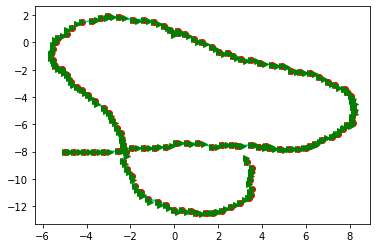

Iter NO:  1  ->  Error:  182233.34
Iter NO:  2  ->  Error:  793.06757
Iter NO:  3  ->  Error:  879.77246
Iter NO:  4  ->  Error:  499.11826
Iter NO:  5  ->  Error:  617.0849
Iter NO:  6  ->  Error:  344.2801
Iter NO:  7  ->  Error:  266.0932
Iter NO:  8  ->  Error:  148.3667
Iter NO:  9  ->  Error:  225.06511
Iter NO:  10  ->  Error:  109.43204


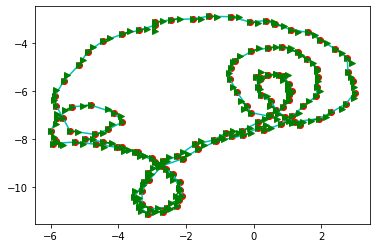

Iter NO:  11  ->  Error:  244.83395
Iter NO:  12  ->  Error:  95.21141
Iter NO:  13  ->  Error:  206.25436
Iter NO:  14  ->  Error:  84.71418
Iter NO:  15  ->  Error:  184.73538
Iter NO:  16  ->  Error:  77.59975
Iter NO:  17  ->  Error:  165.52235
Iter NO:  18  ->  Error:  72.23588
Iter NO:  19  ->  Error:  148.03377
Iter NO:  20  ->  Error:  67.87425


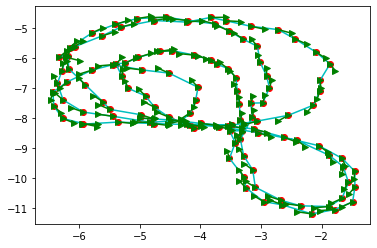

Iter NO:  21  ->  Error:  131.43304
Iter NO:  22  ->  Error:  64.1623
Iter NO:  23  ->  Error:  116.21801
Iter NO:  24  ->  Error:  60.94812
Iter NO:  25  ->  Error:  103.15422
Iter NO:  26  ->  Error:  58.153805
Iter NO:  27  ->  Error:  92.410866
Iter NO:  28  ->  Error:  55.721153
Iter NO:  29  ->  Error:  83.92728
Iter NO:  30  ->  Error:  53.596493


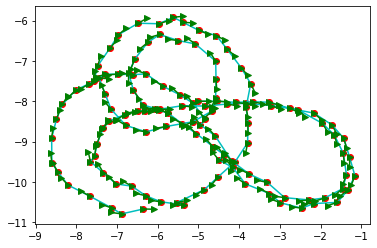

Iter NO:  31  ->  Error:  77.22729
Iter NO:  32  ->  Error:  51.72547
Iter NO:  33  ->  Error:  71.900024
Iter NO:  34  ->  Error:  50.0596
Iter NO:  35  ->  Error:  67.6585
Iter NO:  36  ->  Error:  48.560005
Iter NO:  37  ->  Error:  64.06455
Iter NO:  38  ->  Error:  47.19593
Iter NO:  39  ->  Error:  60.990612
Iter NO:  40  ->  Error:  45.945744


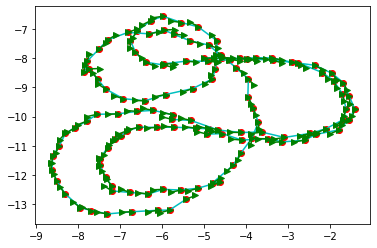

Iter NO:  41  ->  Error:  58.260586
Iter NO:  42  ->  Error:  44.792694
Iter NO:  43  ->  Error:  55.82124
Iter NO:  44  ->  Error:  43.724403
Iter NO:  45  ->  Error:  53.58782
Iter NO:  46  ->  Error:  42.73138
Iter NO:  47  ->  Error:  51.516113
Iter NO:  48  ->  Error:  41.806503
Iter NO:  49  ->  Error:  49.577156
Iter NO:  50  ->  Error:  40.9434


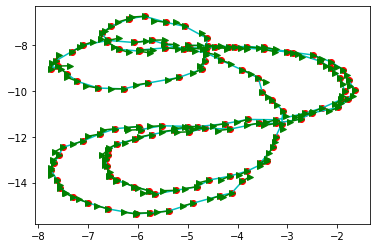

Iter NO:  51  ->  Error:  47.7948
Iter NO:  52  ->  Error:  40.137127
Iter NO:  53  ->  Error:  46.14817
Iter NO:  54  ->  Error:  39.38312
Iter NO:  55  ->  Error:  44.582123
Iter NO:  56  ->  Error:  38.67731
Iter NO:  57  ->  Error:  43.171146
Iter NO:  58  ->  Error:  38.015945
Iter NO:  59  ->  Error:  41.84857
Iter NO:  60  ->  Error:  37.39555


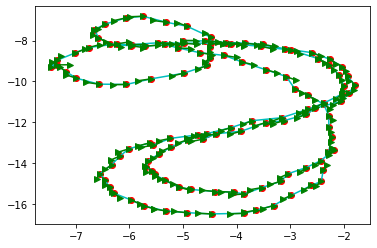

Iter NO:  61  ->  Error:  40.635685
Iter NO:  62  ->  Error:  36.812813
Iter NO:  63  ->  Error:  39.527813
Iter NO:  64  ->  Error:  36.26445
Iter NO:  65  ->  Error:  38.52121
Iter NO:  66  ->  Error:  35.747616
Iter NO:  67  ->  Error:  37.58971
Iter NO:  68  ->  Error:  35.259403
Iter NO:  69  ->  Error:  36.75726
Iter NO:  70  ->  Error:  34.79735


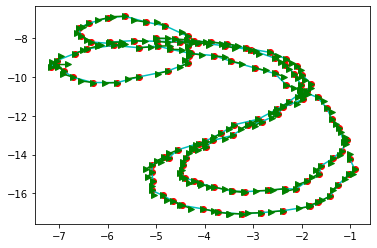

Iter NO:  71  ->  Error:  35.98148
Iter NO:  72  ->  Error:  34.358826
Iter NO:  73  ->  Error:  35.28437
Iter NO:  74  ->  Error:  33.94164
Iter NO:  75  ->  Error:  34.641247
Iter NO:  76  ->  Error:  33.54372
Iter NO:  77  ->  Error:  34.05538
Iter NO:  78  ->  Error:  33.163242
Iter NO:  79  ->  Error:  33.51281
Iter NO:  80  ->  Error:  32.798492


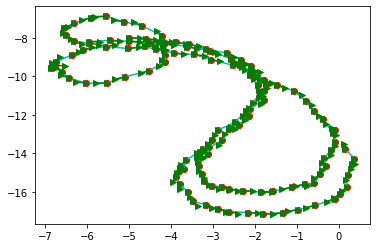

Iter NO:  81  ->  Error:  33.005287
Iter NO:  82  ->  Error:  32.448032
Iter NO:  83  ->  Error:  32.53843
Iter NO:  84  ->  Error:  32.110596
Iter NO:  85  ->  Error:  32.099197
Iter NO:  86  ->  Error:  79.270256
Iter NO:  87  ->  Error:  30.729046
Iter NO:  88  ->  Error:  70.15343
Iter NO:  89  ->  Error:  29.484995
Iter NO:  90  ->  Error:  61.30931


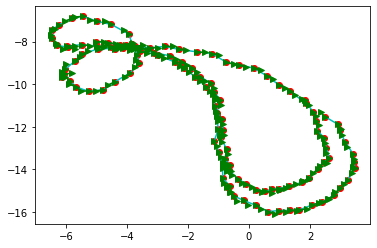

Iter NO:  91  ->  Error:  28.363081
Iter NO:  92  ->  Error:  53.972645
Iter NO:  93  ->  Error:  27.357977
Iter NO:  94  ->  Error:  47.773163
Iter NO:  95  ->  Error:  26.463991
Iter NO:  96  ->  Error:  42.522392
Iter NO:  97  ->  Error:  25.668026
Iter NO:  98  ->  Error:  38.23634
Iter NO:  99  ->  Error:  24.958366
Iter NO:  100  ->  Error:  34.74334


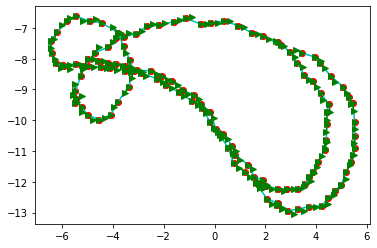

Iter NO:  101  ->  Error:  24.324533
Iter NO:  102  ->  Error:  31.872728
Iter NO:  103  ->  Error:  23.75806
Iter NO:  104  ->  Error:  29.579035
Iter NO:  105  ->  Error:  23.251501
Iter NO:  106  ->  Error:  27.764578
Iter NO:  107  ->  Error:  22.798784
Iter NO:  108  ->  Error:  26.17773
Iter NO:  109  ->  Error:  22.39423
Iter NO:  110  ->  Error:  24.929281


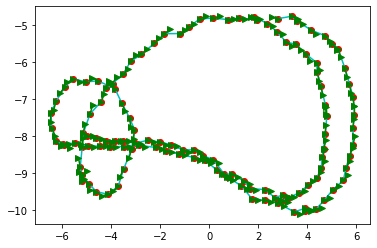

Iter NO:  111  ->  Error:  22.033382
Iter NO:  112  ->  Error:  23.921776
Iter NO:  113  ->  Error:  21.711763
Iter NO:  114  ->  Error:  23.093756
Iter NO:  115  ->  Error:  21.425589
Iter NO:  116  ->  Error:  22.415
Iter NO:  117  ->  Error:  21.171352
Iter NO:  118  ->  Error:  21.876528
Iter NO:  119  ->  Error:  20.945818
Iter NO:  120  ->  Error:  21.424538


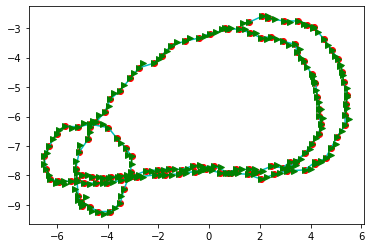

Iter NO:  121  ->  Error:  20.745901
Iter NO:  122  ->  Error:  21.05504
Iter NO:  123  ->  Error:  20.569063
Iter NO:  124  ->  Error:  20.755604
Iter NO:  125  ->  Error:  20.412886
Iter NO:  126  ->  Error:  20.51239
Iter NO:  127  ->  Error:  20.275023
Iter NO:  128  ->  Error:  20.311201
Iter NO:  129  ->  Error:  20.15354
Iter NO:  130  ->  Error:  20.14483


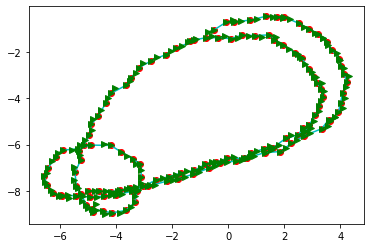

Iter NO:  131  ->  Error:  20.42239
Iter NO:  132  ->  Error:  19.75856
Iter NO:  133  ->  Error:  19.863937
Iter NO:  134  ->  Error:  19.579912
Iter NO:  135  ->  Error:  19.57728
Iter NO:  136  ->  Error:  19.387352
Iter NO:  137  ->  Error:  19.325163
Iter NO:  138  ->  Error:  19.30627
Iter NO:  139  ->  Error:  19.299984
Iter NO:  140  ->  Error:  19.297577


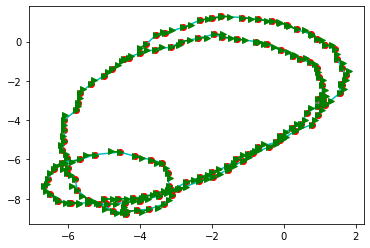

Iter NO:  141  ->  Error:  19.296621
Iter NO:  142  ->  Error:  19.296223
Iter NO:  143  ->  Error:  19.296045
Iter NO:  144  ->  Error:  19.295958
Iter NO:  145  ->  Error:  19.295921
Iter NO:  146  ->  Error:  19.295914
Iter NO:  147  ->  Error:  19.295897
Iter NO:  148  ->  Error:  19.295881
Iter NO:  149  ->  Error:  19.295885
Iter NO:  150  ->  Error:  19.295885


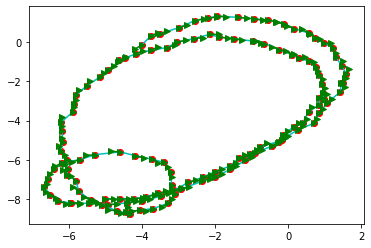

In [7]:
ploting(X)
LM(jacfwd(fun)(jnp.array(X)),sigma,fu,150,X)

In [8]:
#import jax.numpy as jnp
def funf(X):
    x=[X[3*i] for i in range(len(X)//3)]
    y=[X[3*i+1] for i in range(len(X)//3)]
    th=[X[3*i+2] for i in range(len(X)//3)]
    fu = [0 for i in range(420)]
    #fu=[0 for i in range(420)]
    for i in range(139):
        fu[3*i] = x[i_1[i]] + del_x[i]*(jnp.cos(th[i_1[i]])) -  del_y[i]*(jnp.sin(th[i_1[i]])) - x[i_2[i]]
        fu[3*i+1] = y[i_1[i]] + del_y[i]*(jnp.cos(th[i_1[i]])) +  del_x[i]*(jnp.sin(th[i_1[i]])) - y[i_2[i]]
        fu[3*i+2] = th[i_1[i]] + del_theta[i] - th[i_2[i]]   
    fu[417]= X[0]-x_ini[0]
    fu[418]= X[1]-y_ini[0]
    fu[419]= X[2]-theta_ini[0]
    return jnp.array(fu)

In [9]:
#import jax
#j=jacfwd(funf),(jnp.array(X.T))
#print(size(j))
#def f(x):
 #   return jnp.asarray(
  #   [x[0], 5*x[2], 4*x[1]**2 - 2*x[2], x[2] * jnp.sin(x[0])])
J=jacfwd(funf)(jnp.array(X))
j=jac(X)
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")


In [11]:
frobNorm(J, j, str1="mat1", str2="mat2")

Frobenius norm between mat1 and mat2 is: 0.0


## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

Add answer for 2.1 here:
### Explanation :
- Similar to 1-D slam for 2-D we require a residual function , Sigma matrix , Jacobian to proceed through the LM.

- Out of these the Jacobian calculation through analytically took time as we made some small errors. In this case the Jacfwd function helped a lot. We repeatedly checked with the given 'frobnorm' helper function which ultimately gave us the correct jacobian and we found the mistakes we made.

- As mentioned plots are made for every 10 iterations and the error for respective iteration is printed. 

- The main stages which we found are the initial 4-5 stages where LM algorithm rapidly reduced the error and the Shape of the trajectory has also been changed a lot. With **Evo** the trajectory checking was very clear and notable changes are observed while using evo traj.Below are the important plots of transition.



**Experimantation** : 

- Experimentation is done on sigma matrix and lamda in algorithm
  - For sigma matrix the following sets are tried
    - (500 , 700 , 1000)
    - (100 , 500 , 1000)
    - (20  , 500 , 10000)
    - (20  , 1000, 10000)
  - The observation made is that for anchor constraint maximum importance should be given followed by loop closures and a minimal importance for residuals inorder to get a decent estimate.

- Experimentation for lambda in LM algorithm have been done by using 
  - 2 , 5, 10
  - Out of these for $$ lamda = 2 $$ No.of iterations required is increasing and for $$ lamda = 10 $$  The error value is incresing so a good compromise is obtained for $$ lamda = 5 $$
  
 
### EVO - Analysis : 
#### 1. Rpe
![robot-poses-MR-P1.png](./misc/Evo_rpe.png)


|Parameter| Value  |
|:-   | ------------- |
|  max|	0.287000|
|mean |	0.117244|
|median	|0.113903|
|  min	|0.005662|
|rmse	|0.132095|
|sse	|2.076430|
|std	|0.060850|




#### 2. Ape
![robot-poses-MR-P1.png](./misc/Evo_ape.png)

|Parameter| Value  |
|:-   | ------------- |
| max   |	10.229970|
| mean  |	5.310514|
|median	|5.654649|
|  min	|0.000000|
|rmse	|6.182768|
|sse	|4587.193813|
|std    |3.166237|


#### 3. Tra
![robot-poses-MR-P1.png](./misc/Evo_tra.png)

## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

## 2.2 Answer

Add images: take screenshot of the GUI of `g2o_viewer` after optimization for all 3 [[CP-M]] and add here. Briefly describe what you had to do (detailed answer is not expected). g2o could potentially give you close to ground truth trajectory for all 3, but if you are unable to get to close to ground truth, add the best you can get.

![robot-poses-MR-P1.png](./misc/opt_sphere.png)
![robot-poses-MR-P1.png](./misc/opt_intel.png)
![robot-poses-MR-P1.png](./misc/opt_pose.png)

- Without changing any parameters intel and the poses gave almost the ground truth

- But for Sphere part we changed the optimizer from GN to LM and on increasing some iterations (10 to 30) the result came close to ground truth.

- There are few other parameters which we tried on experimenting :) but couldn't observe a change 

###  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now 😛)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer


Your answer here.

<table><tr>
<td> <img src="./misc/Matr.jpeg" alt="Drawing" style="width: 500px;" style="length: 500px;"/> </td>

<td> <img src="./misc/Geo.jpeg" alt="Drawing" style="width: 500px;" style="length: 500px;"/> </td>
</tr></table>

<table><tr>
    <td> <img src="./misc/thet.jpeg" alt="Drawing" style="width: 500px;" style="length: 500px;"/> </td>
</tr></table>    


# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer


Your answer here.

### Fun section
Check the end of your Project-1 homepage on Notion. :)